In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [242]:
train = pd.read_csv('./datasets/train.csv', index_col='id')
test = pd.read_csv('./datasets/test.csv', index_col='id')

df = pd.concat([train, test])

In [243]:
df.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
id,,,,,,
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [244]:
df.describe()

,bone_length,rotting_flesh,hair_length,has_soul
count,900.000000,900.000000,900.000000,900.000000
mean,0.429054,0.504961,0.522163,0.467104
std,0.134744,0.153567,0.170981,0.178150
min,0.000000,0.000000,0.000000,0.000000
25%,0.332085,0.402419,0.396112,0.343909
50%,0.426781,0.505279,0.530294,0.465508
75%,0.518167,0.605218,0.644958,0.589235
max,1.000000,1.000000,1.000000,1.000000


In [245]:
df.bone_length.value_counts()

0.000000    1
0.551497    1
0.525822    1
0.413576    1
0.409617    1
           ..
0.208625    1
0.505424    1
0.505597    1
0.159418    1
0.632675    1
Name: bone_length, Length: 900, dtype: int64

# Hair

In [246]:
bone_ind = df['bone_length'].sort_values().index

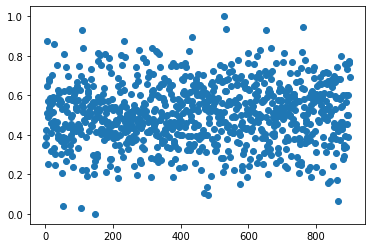

In [247]:
plt.scatter(df.loc[bone_ind].index, df.loc[bone_ind]['rotting_flesh'])

In [248]:
df.loc[bone_ind, 'type'].head(225).value_counts()

Ghost     55
Goblin    21
Ghoul      9
Name: type, dtype: int64

In [249]:
min_Ghost_bone_length = df.loc[bone_ind, 'bone_length'].iloc[0]
mean_Ghost_bone_length = df.loc[bone_ind, 'bone_length'].iloc[225]
print('bone_length mean for Ghost')
print(mean_Ghost_bone_length)
print('varience =', mean_Ghost_bone_length - min_Ghost_bone_length)

bone_length mean for Ghost
0.3321342791974178
varience = 0.3321342791974178


In [250]:
bone_Ghost_mask = df['bone_length'] <= 2*mean_Ghost_bone_length

In [251]:
df.loc[bone_Ghost_mask, 'type'].value_counts()

Goblin    123
Ghost     117
Ghoul     113
Name: type, dtype: int64

# Hair

In [252]:
hair_ind = df['hair_length'].sort_values().index

In [253]:
df.loc[hair_ind, 'type'].head(50).value_counts()

Ghost    18
Name: type, dtype: int64

In [254]:
df.loc[bone_ind, 'type'].head(40).value_counts()

Ghost    16
Ghoul     1
Name: type, dtype: int64

# Soul

In [255]:
soul_ind = df['has_soul'].sort_values().index

In [256]:
df.loc[soul_ind, 'type'].head(50).value_counts()

Ghost    20
Name: type, dtype: int64

# Flesh

In [257]:
flesh_ind = df['rotting_flesh'].sort_values().index

In [258]:
df.loc[flesh_ind, 'type'].head(50).value_counts()

Goblin    12
Ghost      3
Ghoul      3
Name: type, dtype: int64

# REVERSE

# Bone

In [259]:
rev_bone_ind = df['bone_length'].sort_values(ascending=False).index

In [260]:
df.loc[rev_bone_ind, 'type'].head(15).value_counts()

Ghoul    6
Name: type, dtype: int64

# Hair

In [261]:
rev_hair_ind = df['hair_length'].sort_values(ascending=False).index

In [262]:
df.loc[rev_hair_ind, 'type'].head(20).value_counts()

Ghoul    10
Name: type, dtype: int64

# Soul

In [263]:
rev_soul_ind = df['has_soul'].sort_values(ascending=False).index

In [264]:
df.loc[rev_soul_ind, 'type'].head(10).value_counts()

Ghoul    3
Name: type, dtype: int64

# Flesh

In [265]:
rev_flesh_ind = df['rotting_flesh'].sort_values(ascending=False).index

In [266]:
df.loc[rev_flesh_ind, 'type'].head(10).value_counts()

Ghost    4
Name: type, dtype: int64

# Fill types

In [267]:
df.loc[bone_ind[:35], 'type'] = 'Ghost'
df.loc[hair_ind[:40], 'type'] = 'Ghost'
df.loc[soul_ind[:50], 'type'] = 'Ghost'
df.loc[rev_bone_ind[:15], 'type'] = 'Ghoul'
df.loc[rev_hair_ind[:20], 'type'] = 'Ghoul'
df.loc[rev_soul_ind[:10], 'type'] = 'Ghoul'
df.loc[rev_flesh_ind[:10], 'type'] = 'Ghost'

In [268]:
df['type'].value_counts()

Ghost     191
Ghoul     154
Goblin    125
Name: type, dtype: int64

# New train sample

In [269]:
train_df = df.loc[df['type'].notna()]

# Label Encoding

In [270]:
from sklearn.preprocessing import LabelEncoder

In [271]:
le = LabelEncoder()

y = le.fit_transform(train_df['type'])
types = le.classes_

In [272]:
train_df.drop(['color', 'type'], axis=1, inplace=True)
test.drop(['color'], axis=1, inplace=True)

c:\users\kmbs\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [273]:
train_df.head()

,bone_length,rotting_flesh,hair_length,has_soul
id,,,,
0,0.354512,0.350839,0.465761,0.781142
1,0.575560,0.425868,0.531401,0.439899
2,0.467875,0.354330,0.811616,0.791225
4,0.776652,0.508723,0.636766,0.884464
5,0.566117,0.875862,0.418594,0.636438


In [275]:
test.head()

,bone_length,rotting_flesh,hair_length,has_soul
id,,,,
3,0.471774,0.387937,0.706087,0.698537
6,0.427332,0.645024,0.565558,0.451462
9,0.549602,0.491931,0.660387,0.449809
10,0.638095,0.682867,0.471409,0.356924
13,0.361762,0.583997,0.377256,0.276364


# Training simple model: logreg

In [276]:
from sklearn.linear_model import LogisticRegression

In [277]:
clf = LogisticRegression()
clf.fit(train_df, y)

LogisticRegression()

In [279]:
predictions = clf.predict(test)

In [280]:
submission_df = pd.read_csv('./datasets/sample_submission.csv', index_col='id')
submission_df['type'] = types[predictions]

submission_df.to_csv('./results/LogReg_NEW.csv')

# Random Forest

In [287]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=2)
model.fit(train_df, y)
predictions = model.predict(test)

In [288]:
submission_df = pd.read_csv('./datasets/sample_submission.csv', index_col='id')
submission_df['type'] = types[predictions]

submission_df.to_csv('./results/RanFor_NEW.csv')